# Imports

In [1]:
import mne
import numpy as np
import os, sys
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from contextlib import nullcontext
import pickle
from sklearn.model_selection import KFold


class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Split participants

## Functions

In [109]:
def data_processing(l_freq=1, h_freq=45, path_in='./data', output = './processed_data/new/', data_type = 'clean', functions=[], use_filter=True, use_baseline=True, filter_length='auto', n_components=2, verbose=False):
    X_test_all = np.zeros((0, 19, 306))
    X_train_all = np.zeros((0, 19, 306))
    X_valid_all = np.zeros((0, 19, 306))

    y_test_all = np.zeros((0))
    y_train_all = np.zeros((0))
    y_valid_all = np.zeros((0))
    
    files = os.listdir(path_in)
    files = list(filter(lambda x: (x[-4:] == '.set'), files))
    files = set(map(lambda x: x[:3], files))
    files = sorted(files)
    for filename in files:
        word_file = path_in + '/' + filename + '_exp1.set'
        pseudo_file = path_in + '/' + filename + '_exp2.set'
        print(f'Importing {filename}')
        raw_word = mne.io.read_epochs_eeglab(word_file, verbose=False)
        raw_pseudo = mne.io.read_epochs_eeglab(pseudo_file, verbose=False)
        event_ids = {'APos': 1,'RPos': 2,'ONeu': 3,'ANeu': 4,'ONeg': 5,'OPos': 6,'RNeg': 7,'RNeu': 8,'ANeg': 9,'Pseudo': 10}
        raw_pseudo.event_id = event_ids
        raw_word.event_id = event_ids
        raw_pseudo.events[:,2] = 10

        y_word = np.ones(len(raw_word))
        y_pseudo = np.zeros(len(raw_pseudo))

        X = mne.concatenate_epochs([raw_word, raw_pseudo])
        y = np.concatenate([y_word, y_pseudo])

        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
        X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        data = [X_train, X_test, X_valid]

        for i, _ in enumerate(data):
#             print(f'Processing {filename} part {i}')
            data[i] =  mne.concatenate_epochs(data[i])
            if use_baseline:
                data[i] = data[i].apply_baseline(baseline=(None,0), verbose=False)
            if use_filter:
                data[i] = data[i].filter(l_freq=l_freq, h_freq=h_freq, verbose=False, filter_length=filter_length)

            for function in functions:
                data[i] = function(data[i], i, n_components=n_components, verbose=verbose)
                 
            data[i] = data[i].get_data()
            
        X_train, X_test, X_valid = data

        X_train_all = np.concatenate((X_train_all, X_train), axis = 0)
        X_test_all = np.concatenate((X_test_all, X_test), axis = 0)
        X_valid_all = np.concatenate((X_valid_all, X_valid), axis = 0)

        y_train_all = np.concatenate((y_train_all, y_train), axis = 0)
        y_test_all = np.concatenate((y_test_all, y_test), axis = 0)
        y_valid_all = np.concatenate((y_valid_all, y_valid), axis = 0)
        
    output = f'{output}/{data_type}/'
    if not os.path.exists(output):
        os.makedirs(output)
        
    np.save(output + f'X_test.npy', X_test_all)
    np.save(output + f'y_test.npy', y_test_all)
    np.save(output + f'X_train.npy', X_train_all)
    np.save(output + f'y_train.npy', y_train_all)
    np.save(output + f'X_valid.npy', X_valid_all)
    np.save(output + f'y_valid.npy', y_valid_all)
    
    
def data_processing_folds(l_freq=1, h_freq=45, path_in='./data', output = './processed_data/', data_type = 'clean', functions=[], use_filter=True, use_baseline=True, filter_length='auto', n_components=2, verbose=False, num_folds=5):
    files = os.listdir(path_in)
    files = list(filter(lambda x: (x[-4:] == '.set'), files))
    files = set(map(lambda x: x[:3], files))
    files = sorted(files)
    for filename in files:
        word_file = path_in + '/' + filename + '_exp1.set'
        pseudo_file = path_in + '/' + filename + '_exp2.set'
        print(f'Importing {filename}')
        raw_word = mne.io.read_epochs_eeglab(word_file, verbose=False)
        raw_pseudo = mne.io.read_epochs_eeglab(pseudo_file, verbose=False)
        event_ids = {'APos': 1,'RPos': 2,'ONeu': 3,'ANeu': 4,'ONeg': 5,'OPos': 6,'RNeg': 7,'RNeu': 8,'ANeg': 9,'Pseudo': 10}
        raw_pseudo.event_id = event_ids
        raw_word.event_id = event_ids
        raw_pseudo.events[:,2] = 10
        
        valid_word_len = int(len(raw_word)*0.15)
        valid_pseudo_len = int(len(raw_pseudo)*0.15)
        
        y_word = np.ones(len(raw_word))
        y_pseudo = np.zeros(len(raw_pseudo))
        
        X = mne.concatenate_epochs([raw_word[valid_word_len:], raw_pseudo[valid_pseudo_len:]])
        y = np.concatenate([y_word[valid_word_len:], y_pseudo[valid_pseudo_len:]])
        
        X_valid = mne.concatenate_epochs([raw_word[:valid_word_len], raw_pseudo[:valid_pseudo_len]])
        y_valid = np.concatenate([y_word[:valid_word_len], y_pseudo[:valid_pseudo_len]])
        
        kfold = KFold(n_splits=num_folds, shuffle=True)
        fold = 0
        for train, test in kfold.split(X, y):
            X_train = X[train]
            X_test = X[test]
            y_test = y[test]
            y_train = y[train]
            if fold == 0:
                data = [X_train, X_test, X_valid]
            else:
                data = [X_train, X_test]

            for i, _ in enumerate(data):
                if use_baseline:
                    data[i] = data[i].apply_baseline(baseline=(None,0), verbose=False)
                if use_filter:
                    data[i] = data[i].filter(l_freq=l_freq, h_freq=h_freq, verbose=False, filter_length=filter_length)

                for function in functions:
                    data[i] = function(data[i], i, n_components=n_components, verbose=verbose)

                data[i] = data[i].get_data()
                
            output_path = f'{output}/{data_type}/folds/fold_{fold}/patient_{filename}/'
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            if fold == 0:
                X_train, X_test, X_valid = data
            else:
                X_train, X_test = data
            np.save(output_path + f'X_valid.npy', X_valid)
            np.save(output_path + f'y_valid.npy', y_valid)
            np.save(output_path + f'X_test.npy', X_test)
            np.save(output_path + f'y_test.npy', y_test)
            np.save(output_path + f'X_train.npy', X_train)
            np.save(output_path + f'y_train.npy', y_train)

            fold += 1

def concatenate_patients(path_in='./processed_data/', output='./processed_data/', data_type='clean', num_folds=5):
    for fold in range(0, num_folds):
        X_test_all = np.zeros((0, 19, 306))
        X_train_all = np.zeros((0, 19, 306))
        X_valid_all = np.zeros((0, 19, 306))

        y_test_all = np.zeros((0))
        y_train_all = np.zeros((0))
        y_valid_all = np.zeros((0))
        
        fold_path = f'{path_in}{data_type}/folds/fold_{fold}'
        patients = os.listdir(fold_path)
        for patient in patients:
            X_train = np.load(f'{fold_path}/{patient}/X_train.npy')
            X_test = np.load(f'{fold_path}/{patient}/X_test.npy')
            X_valid = np.load(f'{fold_path}/{patient}/X_valid.npy')
            y_train = np.load(f'{fold_path}/{patient}/y_train.npy')
            y_test = np.load(f'{fold_path}/{patient}/y_test.npy')
            y_valid = np.load(f'{fold_path}/{patient}/y_valid.npy')
            
            X_train_all = np.concatenate((X_train_all, X_train), axis = 0)
            X_test_all = np.concatenate((X_test_all, X_test), axis = 0)

            y_train_all = np.concatenate((y_train_all, y_train), axis = 0)
            y_test_all = np.concatenate((y_test_all, y_test), axis = 0)
            
        output = f'{path_in}{data_type}/folds/'
        np.save(output + f'X_test_fold_{fold}.npy', X_test_all)
        np.save(output + f'y_test_fold_{fold}.npy', y_test_all)
        np.save(output + f'X_train_fold_{fold}.npy', X_train_all)
        np.save(output + f'y_train_fold_{fold}.npy', y_train_all)
        np.save(output + f'X_valid_fold_{fold}.npy', X_valid)
        np.save(output + f'y_valid_fold_{fold}.npy', y_valid)
        
        
def xDawn_denosing(data, i, n_components=2, verbose=False, **kwargs):
    if not verbose:
        cm = HiddenPrints()
    else:
        cm = nullcontext()
    with cm:
        data.events = mne.merge_events(data.events, [1,2,3,4,5,6,7,8,9], 1, replace_events=True)
        data.event_id = {'Word': 1, 'Pseudo': 10}
        if i == 0:
            temp_syg = data.get_data()
            temp_syg = temp_syg.reshape([temp_syg.shape[1],temp_syg.shape[0]*temp_syg.shape[2]]) #ERROR
            signal_cov = mne.compute_raw_covariance(mne.io.RawArray(temp_syg, data[0].info), verbose=verbose)
            global xd
            xd = mne.preprocessing.Xdawn(n_components=n_components, signal_cov=signal_cov)
            xd.fit(data)
        epochs_denoised = xd.apply(data)
        data = next(iter(epochs_denoised.values())) #Potencjal wywyolany 200ms gorka
    return data
    

def standardization(data, i, **kwargs):
    data_temp = data.get_data()
    mean = np.mean(data_temp, axis=2).reshape(data_temp.shape[0], data_temp.shape[1], 1)
    std = np.std(data_temp, axis=(1, 2)).reshape(data_temp.shape[0], 1, 1)
    data._data = (data_temp - mean)/std
    return data


def standardizatin_common(data, i, **kwargs):
    data_temp = data.get_data()
    if i == 0:
        global mean
        mean = np.mean(np.mean(data_temp, axis=2).reshape(data_temp.shape[0], data_temp.shape[1], 1),axis=0)
        global std
        std = np.mean(np.mean(np.std(data_temp, axis=(1, 2)).reshape(data_temp.shape[0], 1, 1)))
    data._data = (data_temp - mean)/std
    return data

In [121]:
def visualize_data(l_freq=1, h_freq=45, path_in='./data', output = './processed_data/new/', data_type = 'clean', functions=[], use_filter=True, use_baseline=True, filter_length='auto', n_components=2, verbose=False):
    X_test_all = np.zeros((0, 19, 306))
    X_train_all = np.zeros((0, 19, 306))
    X_valid_all = np.zeros((0, 19, 306))

    y_test_all = np.zeros((0))
    y_train_all = np.zeros((0))
    y_valid_all = np.zeros((0))
    
    files = os.listdir(path_in)
    files = list(filter(lambda x: (x[-4:] == '.set'), files))
    files = set(map(lambda x: x[:3], files))
    files = sorted(files)
    files =[files[0]]
    for filename in files:
        word_file = path_in + '/' + filename + '_exp1.set'
        pseudo_file = path_in + '/' + filename + '_exp2.set'
        print(f'Importing {filename}')
        raw_word = mne.io.read_epochs_eeglab(word_file, verbose=False)
        raw_pseudo = mne.io.read_epochs_eeglab(pseudo_file, verbose=False)
        event_ids = {'APos': 1,'RPos': 2,'ONeu': 3,'ANeu': 4,'ONeg': 5,'OPos': 6,'RNeg': 7,'RNeu': 8,'ANeg': 9,'Pseudo': 10}
        raw_pseudo.event_id = event_ids
        raw_word.event_id = event_ids
        raw_pseudo.events[:,2] = 10

        y_word = np.ones(len(raw_word))
        y_pseudo = np.zeros(len(raw_pseudo))

        X = mne.concatenate_epochs([raw_word, raw_pseudo])
        y = np.concatenate([y_word, y_pseudo])

        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
        X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        data = [[X_train[0]], [X_test[0]], [X_valid[0]]]

        for i, _ in enumerate(data):
#             print(f'Processing {filename} part {i}')
            data[i] =  mne.concatenate_epochs(data[i])
            plt.plot(data[i].get_data()[0,0])
            plt.show()
            if use_baseline:
                data[i] = data[i].apply_baseline(baseline=(None,0), verbose=False)
                plt.plot(data[i].get_data()[0,0])
                plt.show()
            if use_filter:
                data[i] = data[i].filter(l_freq=l_freq, h_freq=h_freq, verbose=False, filter_length=filter_length)

            for function in functions:
                data[i] = function(data[i], i, n_components=n_components, verbose=verbose)

## Data processing clean 

In [48]:
data_processing(data_type = 'clean', functions=[])

Importing B01
Importing B02
Importing B03
Importing B04
Importing B05
Importing B06
Importing B07
Importing B08
Importing B09
Importing B10
Importing B11
Importing B15
Importing B17
Importing B18
Importing B20
Importing B21
Importing B22
Importing B24
Importing B26
Importing B27
Importing B28
Importing B29
Importing B30
Importing B31
Importing B32
Importing B33
Importing B34
Importing B35
Importing B36
Importing B37


Importing B01


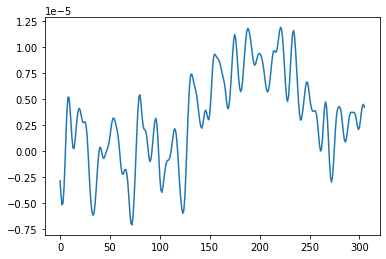

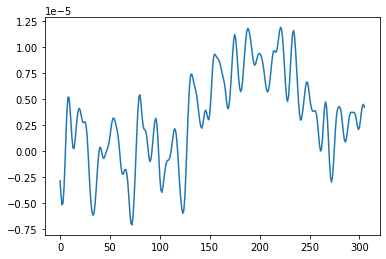

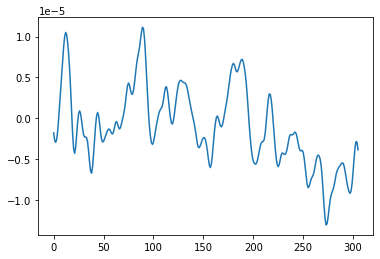

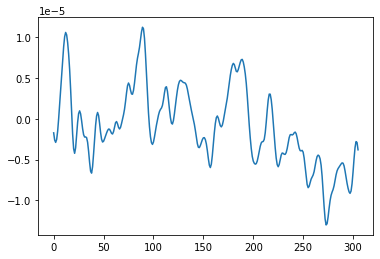

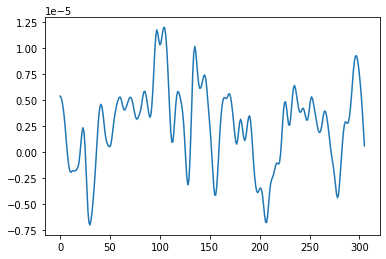

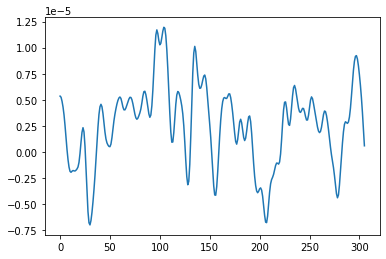

In [122]:
visualize_data(data_type = 'clean', functions=[])

## Data processing xDawn 

In [13]:
data_processing(data_type = 'xDawn', functions=[xDawn_denosing])

Importing B01
Importing B02


KeyboardInterrupt: 

## Data processing standardization common

In [51]:
data_processing(data_type = 'standardization_common', functions=[standardizatin_common])

Importing B01
Importing B02
Importing B03
Importing B04
Importing B05
Importing B06
Importing B07
Importing B08
Importing B09
Importing B10
Importing B11
Importing B15
Importing B17
Importing B18
Importing B20
Importing B21
Importing B22
Importing B24
Importing B26
Importing B27
Importing B28
Importing B29
Importing B30
Importing B31
Importing B32
Importing B33
Importing B34
Importing B35
Importing B36
Importing B37


# Per participant

## Functions

In [15]:
def data_processing_participants(l_freq=1, h_freq=45, path_in='./data', output = './processed_data/', data_type = 'clean', functions=[], use_filter=True, use_baseline=True, filter_length='auto', n_components=2, verbose=False):
    X_all = []
    y_all = []
    
    files = os.listdir(path_in)
    files = list(filter(lambda x: (x[-4:] == '.set'), files))
    files = set(map(lambda x: x[:3], files))
    files = sorted(files)
    for filename in files:
        word_file = path_in + '/' + filename + '_exp1.set'
        pseudo_file = path_in + '/' + filename + '_exp2.set'
        print(f'Importing {filename}')
        raw_word = mne.io.read_epochs_eeglab(word_file, verbose=False)
        raw_pseudo = mne.io.read_epochs_eeglab(pseudo_file, verbose=False)
        event_ids = {'APos': 1,'RPos': 2,'ONeu': 3,'ANeu': 4,'ONeg': 5,'OPos': 6,'RNeg': 7,'RNeu': 8,'ANeg': 9,'Pseudo': 10}
        raw_pseudo.event_id = event_ids
        raw_word.event_id = event_ids
        raw_pseudo.events[:,2] = 10

        y_word = np.ones(len(raw_word))
        y_pseudo = np.zeros(len(raw_pseudo))

        X = mne.concatenate_epochs([raw_word, raw_pseudo])
        y = np.concatenate([y_word, y_pseudo])
        
        if use_baseline:
            X = X.apply_baseline(baseline=(None,0), verbose=False)
        if use_filter:
            X = X.filter(l_freq=l_freq, h_freq=h_freq, verbose=False, filter_length=filter_length)

        for function in functions:
            X = function(X, n_components=n_components, verbose=verbose)

        X = X.get_data()
            
        X_all.append(X)
        y_all.append(y)
        
    output = f'{output}/{data_type}/'
    if not os.path.exists(output):
        os.makedirs(output)
        
    with open(f"{output}/X.pkl", "wb") as fp:
        pickle.dump(X_all, fp)
    with open(f"{output}/y.pkl", "wb") as fp:
        pickle.dump(y_all, fp)

        
        
def xDawn_denosing_participants(data, n_components=2, verbose=False, **kwargs):
    if not verbose:
        cm = HiddenPrints()
    else:
        cm = nullcontext()
    with cm:
        data.events = mne.merge_events(data.events, [1,2,3,4,5,6,7,8,9], 1, replace_events=True)
        data.event_id = {'Word': 1, 'Pseudo': 10}
        temp_syg = data.get_data()
        temp_syg = temp_syg.reshape([temp_syg.shape[1],temp_syg.shape[0]*temp_syg.shape[2]]) #ERROR
        signal_cov = mne.compute_raw_covariance(mne.io.RawArray(temp_syg, data[0].info), verbose=verbose)
        xd = mne.preprocessing.Xdawn(n_components=n_components, signal_cov=signal_cov)
        xd.fit(data)
        epochs_denoised = xd.apply(data)
        data = next(iter(epochs_denoised.values())) #Potencjal wywyolany 200ms gorka
    return data
    

def standardization_participants(data, **kwargs):
    data_temp = data.get_data()
    mean = np.mean(data_temp, axis=2).reshape(data_temp.shape[0], data_temp.shape[1], 1)
    std = np.std(data_temp, axis=(1, 2)).reshape(data_temp.shape[0], 1, 1)
    data._data = (data_temp - mean)/std
    return data


def standardizatin_common_participants(data, **kwargs):
    data_temp = data.get_data()
    mean = np.mean(np.mean(data_temp, axis=2).reshape(data_temp.shape[0], data_temp.shape[1], 1),axis=0)
    std = np.mean(np.mean(np.std(data_temp, axis=(1, 2)).reshape(data_temp.shape[0], 1, 1)))
    data._data = (data_temp - mean)/std
    return data

def split_participants(data_type = '', output = './processed_data/'):
    with open(f'./{output}/{data_type}/X.pkl', 'rb') as f:
        X_all = pickle.load(f)
    with open(f'./{output}/{data_type}/y.pkl', 'rb') as f:
        y_all = pickle.load(f)
    
    X_test_all = np.zeros((0, 19, 306))
    X_train_all = np.zeros((0, 19, 306))
    X_valid_all = np.zeros((0, 19, 306))

    y_test_all = np.zeros((0))
    y_train_all = np.zeros((0))
    y_valid_all = np.zeros((0))

    for i in range(0, 20):
        X_train_all = np.concatenate((X_train_all, X_all[i]), axis = 0)
        y_train_all = np.concatenate((y_train_all, y_all[i]), axis = 0)

    for i in range(20, 25):
        X_test_all = np.concatenate((X_test_all, X_all[i]), axis = 0)
        y_test_all = np.concatenate((y_test_all, y_all[i]), axis = 0)

    for i in range(25, 30):
        X_valid_all = np.concatenate((X_valid_all, X_all[i]), axis = 0)
        y_valid_all = np.concatenate((y_valid_all, y_all[i]), axis = 0)
                       
    output = f'{output}/{data_type}/'
    if not os.path.exists(output):
        os.makedirs(output)
        
    np.save(output + f'X_test.npy', X_test_all)
    np.save(output + f'y_test.npy', y_test_all)
    np.save(output + f'X_train.npy', X_train_all)
    np.save(output + f'y_train.npy', y_train_all)
    np.save(output + f'X_valid.npy', X_valid_all)
    np.save(output + f'y_valid.npy', y_valid_all)
    
def split_participants_folds(data_type = '', output = './processed_data/', num_folds=5):
    with open(f'./{output}/{data_type}/X.pkl', 'rb') as f:
        X_all = pickle.load(f)
    with open(f'./{output}/{data_type}/y.pkl', 'rb') as f:
        y_all = pickle.load(f)

    X_test_all = np.zeros((0, 19, 306))
    X_train_all = np.zeros((0, 19, 306))
    X_valid_all = np.zeros((0, 19, 306))

    y_test_all = np.zeros((0))
    y_train_all = np.zeros((0))
    y_valid_all = np.zeros((0))

    output = f'{output}/{data_type}/folds/'
    if not os.path.exists(output):
        os.makedirs(output)

    for i in range(25, 30):
        X_valid_all = np.concatenate((X_valid_all, X_all[i]), axis = 0)
        y_valid_all = np.concatenate((y_valid_all, y_all[i]), axis = 0)

    np.save(output + f'X_valid.npy', X_valid_all)
    np.save(output + f'y_valid.npy', y_valid_all)

    kfold = KFold(n_splits=num_folds, shuffle=False)
    fold = 0
    for train, test in kfold.split(X_all[:25], y_all[:25]):
        X_test = np.zeros((0, 19, 306))
        X_train = np.zeros((0, 19, 306))
        y_test = np.zeros((0))
        y_train = np.zeros((0))

        for i in train:
            X_train = np.concatenate((X_train, X_all[i]), axis = 0)
            y_train = np.concatenate((y_train, y_all[i]), axis = 0)
        for i in test:
            X_test = np.concatenate((X_test, X_all[i]), axis = 0)
            y_test = np.concatenate((y_test, y_all[i]), axis = 0)

        np.save(output + f'X_test_fold_{fold}.npy', X_test)
        np.save(output + f'y_test_fold_{fold}.npy', y_test)
        np.save(output + f'X_train_fold_{fold}.npy', X_train)
        np.save(output + f'y_train_fold_{fold}.npy', y_train)
        fold +=1

## Data processing clean participants

In [19]:
data_processing_participants(data_type = 'clean_participants', functions=[])

Importing B01
Importing B02
Importing B03
Importing B04
Importing B05
Importing B06
Importing B07
Importing B08
Importing B09
Importing B10
Importing B11
Importing B15
Importing B17
Importing B18
Importing B20
Importing B21
Importing B22
Importing B24
Importing B26
Importing B27
Importing B28
Importing B29
Importing B30
Importing B31
Importing B32
Importing B33
Importing B34
Importing B35
Importing B36
Importing B37


In [35]:
split_participants(data_type = 'clean_participants')

In [16]:
split_participants_folds(data_type = 'clean_participants')

## Data processing xDawn participants

In [36]:
data_processing_participants(data_type = 'xDawn_participants', functions=[xDawn_denosing_participants])

Importing B01
Importing B02
Importing B03
Importing B04
Importing B05
Importing B06
Importing B07
Importing B08
Importing B09
Importing B10
Importing B11
Importing B15
Importing B17
Importing B18
Importing B20
Importing B21
Importing B22
Importing B24
Importing B26
Importing B27
Importing B28
Importing B29
Importing B30
Importing B31
Importing B32
Importing B33
Importing B34
Importing B35
Importing B36
Importing B37


In [37]:
split_participants(data_type = 'xDawn_participants')

In [17]:
split_participants_folds(data_type = 'xDawn_participants')

## Data processing standardization common participants

In [38]:
data_processing_participants(data_type = 'standardization_common_participants', functions=[standardizatin_common_participants])

Importing B01
Importing B02
Importing B03
Importing B04
Importing B05
Importing B06
Importing B07
Importing B08
Importing B09
Importing B10
Importing B11
Importing B15
Importing B17
Importing B18
Importing B20
Importing B21
Importing B22
Importing B24
Importing B26
Importing B27
Importing B28
Importing B29
Importing B30
Importing B31
Importing B32
Importing B33
Importing B34
Importing B35
Importing B36
Importing B37


In [39]:
split_participants(data_type = 'standardization_common_participants')

In [18]:
split_participants_folds(data_type = 'standardization_common_participants')

## Data processing clean folds

In [ ]:
data_processing_folds(data_type = 'clean', functions=[])

In [ ]:
concatenate_patients(data_type = 'clean')

## Data processing xDawn folds

In [113]:
data_processing_folds(data_type = 'xDawn', functions=[xDawn_denosing])

Importing B01
Importing B02
Importing B03
Importing B04
Importing B05
Importing B06
Importing B07
Importing B08
Importing B09
Importing B10
Importing B11
Importing B15
Importing B17
Importing B18
Importing B20
Importing B21
Importing B22
Importing B24
Importing B26
Importing B27
Importing B28
Importing B29
Importing B30
Importing B31
Importing B32
Importing B33
Importing B34
Importing B35
Importing B36
Importing B37


In [114]:
concatenate_patients(data_type = 'xDawn')

## Data processing standardization common folds

In [115]:
data_processing_folds(data_type = 'standardization_common', functions=[standardizatin_common])

Importing B01
Importing B02
Importing B03
Importing B04
Importing B05
Importing B06
Importing B07
Importing B08
Importing B09
Importing B10
Importing B11
Importing B15
Importing B17
Importing B18
Importing B20
Importing B21
Importing B22
Importing B24
Importing B26
Importing B27
Importing B28
Importing B29
Importing B30
Importing B31
Importing B32
Importing B33
Importing B34
Importing B35
Importing B36
Importing B37


In [116]:
concatenate_patients(data_type = 'standardization_common')